# Stylized Colorization - Using GAN

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy

In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
import PIL
import PIL.Image


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2022-07-09 16:16:13.793745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:16:13.818916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:16:13.819209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
tf.__version__


'2.9.1'

## Load DataSet


In [5]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab(img):
        image = tf.cast(img, tf.float16)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float16)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float16)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float16)
    

    #TODO add data argumentation.
    nrBatches = len(train_ds)
    
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2),

    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0))))

    train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds))
    train_ds = train_ds.take(int(train_size * nrBatches))
    test_ds = train_ds.skip(int(train_size * nrBatches)).take(int((1.0 - train_size) * nrBatches))

    return configure_for_performance(train_ds, AUTOTUNE, 0), configure_for_performance(test_ds, AUTOTUNE, 0)


In [6]:
BATCH_SIZE = 24
IMAGE_SIZE = (64, 64)
EPOCHS = 128

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE, 0.85)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


Found 184438 files belonging to 1 classes.


2022-07-09 16:16:16.687636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 16:16:16.688656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:16:16.688836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:16:16.688942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 184438 files belonging to 1 classes.
Number of batches 6532 of 24 elements


## Augment DataSet
By augmenting the image, it can reduce overfitting since no image will be the same between each epoch.

In [ ]:
trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.3)
])


def func(x, y):
    aX = trainAug(x)
    return (aX, aX)


trainAugmentedDS = (
    train_images
    .map(func,
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


# Example Data

2022-07-09 16:16:20.901409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


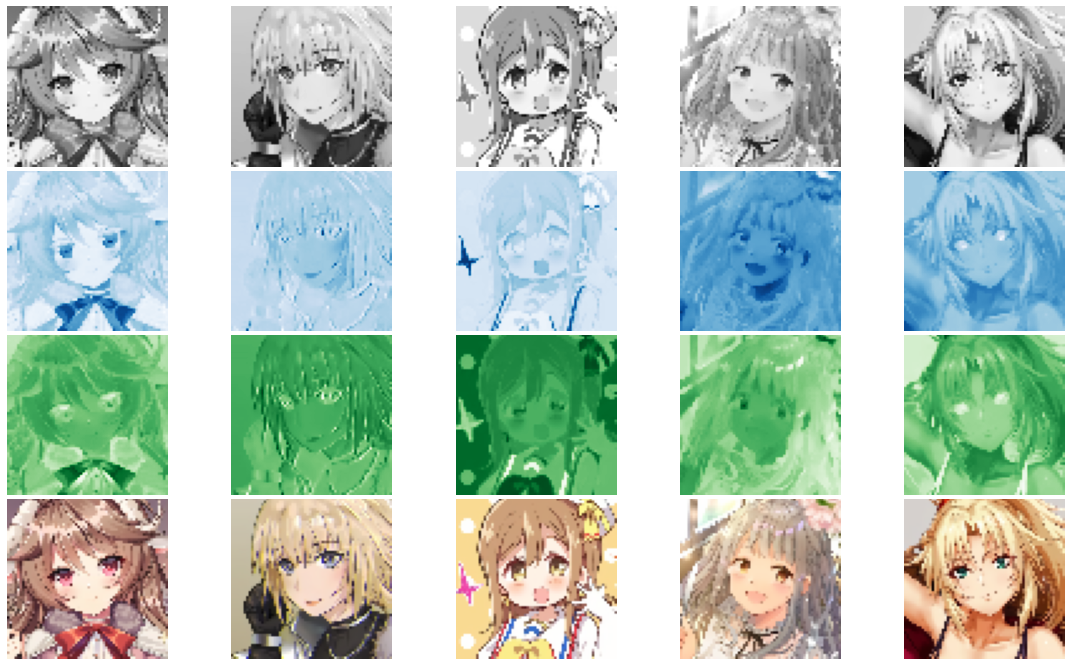

In [7]:
num_examples_to_generate = 9

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for images in train_images.take(1):
    for i in range(0, 5):
        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        trainLAB = trainImage[i, :, :].numpy().astype(dtype='float32')
        ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainLAB, cmap='gray')
        plt.axis("off")
        ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[i, :, :, 0], cmap='Blues')
        plt.axis("off")
        ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[i, :, :, 1], cmap='Greens')
        plt.axis("off")
        expectedImage = expectedImage[i, :, :, :].numpy().astype(dtype='float32') * 128
        RGBImage = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        RGBImage[:, :, 0] = trainLAB[:, :, 0]
        RGBImage[:, :, 1:] = expectedImage
        rgbExpected = lab2rgb(RGBImage)
        ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
        plt.imshow(rgbExpected)
        plt.axis("off")
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Augmented DataSet

In [ ]:
bathc_iter = iter(trainAugmentedDS)
image_batch, expected_batch = next(bathc_iter)

nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


# Create Model

In [8]:
def create_generator(hp, input_shape):
    model = tf.keras.Sequential()

    activation_dict = {
        'leaky_relu': layers.LeakyReLU(dtype='float32'),
        'relu': layers.ReLU(alpha=0.2, dtype='float32')
    }
    activation_function = hp.Choice('activation function', ['relu', 'leaky_relu'])

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('generator_number_layers', min_value=3, max_value=4, step=1)

    hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
    hp_kernel_size = 4
    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    regularization = hp.Int(
        'regularization', min_value=4, max_value=5, step=1)

    batch_norm = hp.Boolean('batch_norm')
    use_upscale = hp.Boolean('use_upscale')

    batch_norm = True
    hp_kernel_filter_size_l0 = 6
    num_layers = 2
    use_upscale = 0

    max_filters_size = 1024

    for i in range(0, num_layers):
        filter_size = 2 ** (hp_kernel_filter_size_l0 + i)
        filter_size = min(max_filters_size, filter_size)

        #model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init, dtype='float32'))
        # if batch_norm == True:
        #    model.add(layers.BatchNormalization())
        # model.add(layers.LeakyReLU(alpha=0.2,dtype='float32'))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, dtype='float32'))
        if batch_norm:
            model.add(layers.BatchNormalization(dtype='float32'))
        model.add(activation_dict[activation_function])

    hp_kernel_filter_size_latent = (hp_kernel_filter_size_l0 + num_layers)
    #latent_space = hp.Int('latent_space', min_value=64, max_value=1024, step=64)

    #
    encoder_last_conv2 = layers.Conv2D(2 ** hp_kernel_filter_size_latent, (3, 3), padding='same', kernel_initializer=kernel_init, dtype='float32')
    model.add(encoder_last_conv2)
    if batch_norm:
        model.add(layers.BatchNormalization(dtype='float32'))
    model.add(activation_dict[activation_function])

    model.add(layers.ActivityRegularization(l1=10 ** -regularization, dtype='float32'))

    # Latent Space
    latent_layer = layers.Flatten(name="latentspace")
    model.add(latent_layer)

    noise_layer = layers.GaussianNoise(stddev=0.005)
    model.add(noise_layer)

    # TODO add dense lantent space.

    #

    model.add(layers.Reshape(target_shape=(encoder_last_conv2.output_shape[1], encoder_last_conv2.output_shape[2], encoder_last_conv2.output_shape[3])))

    #
    model.add(layers.Conv2D(2 ** (hp_kernel_filter_size_latent - 1), (3, 3), padding='same', kernel_initializer=kernel_init, dtype='float32'))
    if batch_norm == True:
        model.add(layers.BatchNormalization(dtype='float32'))
    model.add(activation_dict[activation_function])

    hp_kernel_filter_size_l1 = hp_kernel_filter_size_latent - 1

    for i in range(0, num_layers):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)
        filter_size = min(max_filters_size, filter_size)

        if use_upscale:
            model.add(layers.UpSampling2D(size=(2, 2), dtype='float32'))
        else:
            model.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=hp_kernel_size,
                                             padding='same', strides=(2, 2), kernel_initializer=kernel_init, dtype='float32'))
            if batch_norm:
                model.add(layers.BatchNormalization(dtype='float32'))
            model.add(activation_dict[activation_function])

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(activation_dict[activation_function])

    model.add(layers.Conv2D(2, 7, padding='same', kernel_initializer=kernel_init, dtype='float32'))
    if batch_norm == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    return model


In [9]:
def make_discriminator_model(hp, input_size):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    n_layers = hp.Int('discriminator_number_layers', min_value=1, max_value=3, step=1)
    hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)

    hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.5, step=0.1)

    #
    model.add(layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same',
                            input_shape=input_size))
    model.add(layers.BatchNormalization(dtype='float32'))
    model.add(layers.LeakyReLU(alpha=0.2, dtype='float32'))

    max_filters_size = 1024

    #
    n_layers = 3
    for i in range(0, n_layers):
        filter_size = 128 * (2 ** i)
        filter_size = min(max_filters_size, filter_size)
        #
        model.add(layers.Conv2D(filter_size, kernel_size=4,
                                strides=(2, 2), use_bias=False, padding='same', kernel_initializer=kernel_init, dtype='float32'))
        model.add(layers.BatchNormalization(dtype='float32'))
        model.add(layers.LeakyReLU(alpha=0.2, dtype='float32'))
        # model.add(layers.Dropout(hp_drop_rate))

    # model.add(layers.Conv2D(1, kernel_size=(4, 4), strides=(
    #    2, 2), padding='valid', use_bias=False, kernel_initializer=kernel_init))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid', dtype='float32'))

    return model


In [14]:
def create_model(hp, image_size):

    class DCGAN(keras.Model):

        def __init__(self, generator_model, discriminator_model, **kwargs):
            super(DCGAN, self).__init__(**kwargs)
            self.generator = generator_model
            self.discriminator = discriminator_model
            self.latent_space_size = generator_model.input_shape

            self.cross_entropy = tf.keras.losses.BinaryCrossentropy(
                from_logits=False)

            self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
            self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
            self.total_loss_tracker = keras.metrics.Mean(name="loss")
            self.acc_tracker = keras.metrics.Mean(name="accuracy")

        def generator_loss(self, fake_output):

            return self.cross_entropy(tf.ones_like(fake_output), fake_output)

        def discriminator_loss(self, real_output, smooth=0.05):

            # label for real image is (1-smooth)
            real_loss = self.cross_entropy(tf.ones_like(
                real_output)*(1-smooth), real_output)

            return real_loss

        def total_loss(self, real_output, fake_output, smooth=0.05):
            # label for real image is (1-smooth)
            real_loss = self.cross_entropy(tf.ones_like(
                real_output)*(1-smooth), real_output)

            fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)

            total_loss = real_loss + fake_loss

            return total_loss

        def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
            self.generator.load_weights(filepath+'generator', by_name, skip_mismatch, options)
            self.discriminator.load_weights(filepath+'discriminator', by_name, skip_mismatch, options)

        def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
            self.generator.save_weights(filepath+'generator', overwrite, save_format, options)
            self.discriminator.save_weights(filepath+'discriminator', overwrite, save_format, options)

        def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
            super(DCGAN, self).compile(**kwargs)
            self.generator_optimizer = generator_optimizer
            self.discriminator_optimizer = discriminator_optimizer

        def summary(self):
            self.generator.summary()
            self.discriminator.summary()

        def fit(self, *args, **kwargs):
            self.validation_data = kwargs.get("validation_data")
            self.batch_size = kwargs.get("batch_size")
            return super(DCGAN, self).fit(*args, **kwargs)

        @tf.function
        def train_step(self, data):

            # Extract train and result data.
            trainX, trainY = data

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

                # generate image using generator
                generated_image = self.generator(trainX, training=True)

                # discriminator's prediction for real image
                real_output = self.discriminator(trainY, training=True)

                # discriminator's estimate for fake image
                fake_output = self.discriminator(
                    generated_image, training=True)

                # compute loss
                gen_loss = self.generator_loss(fake_output)
                disc_loss = self.discriminator_loss(real_output)
                loss = self.total_loss(real_output, fake_output)

                # optimize generator first
                generator_grad = gen_tape.gradient(
                    gen_loss, self.generator.trainable_variables)
                discriminator_grad = disc_tape.gradient(
                    disc_loss, self.discriminator.trainable_variables)

                # optimize discriminator after generator
                self.generator_optimizer.apply_gradients(
                    zip(generator_grad, self.generator.trainable_variables))
                self.discriminator_optimizer.apply_gradients(
                    zip(discriminator_grad, self.discriminator.trainable_variables))

                self.total_loss_tracker.update_state(loss)
                self.gen_loss_tracker.update_state(gen_loss)
                self.disc_loss_tracker.update_state(disc_loss)
                self.acc_tracker.update_state(tf.math.reduce_mean(fake_output))

            result = {
                "loss": self.total_loss_tracker.result(),
                "accuracy": tf.math.reduce_mean(fake_output),
                "generator_loss": self.gen_loss_tracker.result(),
                "discriminator_loss": self.disc_loss_tracker.result()
            }

            return result

        def test_step(self, data):
            # Unpack the data
            trainValX, trainValY = data
            generated_image = self.generator(trainValX, training=False)
            real_output = self.discriminator(trainValY, training=True)
            fake_output = self.discriminator(
                generated_image, training=False)
            gen_val_loss = self.generator_loss(fake_output)
            disc_val_loss = self.discriminator_loss(real_output, fake_output)

            result["val_loss"] = disc_val_loss
            result["val_accuracy"] = tf.math.reduce_mean(fake_output)
            # Return a dict mapping metric names to current value.
            # Note that it will include the loss (tracked in self.metrics).
            return result

        @property
        def metrics(self):
            return [self.gen_loss_tracker, self.disc_loss_tracker, self.acc_tracker]

    # Create the models.
    discriminator = make_discriminator_model(hp, (image_size[0], image_size[1], 2))
    generator = create_generator(hp, (image_size[0], image_size[1], 1))

    #
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-2, 2e-3, 2e-4])
    hp_generator_optimizer = hp.Choice('generator_optimizer', ['sgd', 'adam', 'rmsprop'])
    hp_discriminator_optimizer = hp.Choice('discriminator_optimizer', ['sgd', 'adam', 'rmsprop'])
#
    ## #
    generator_optimizer = tf.keras.optimizers.get('rmsprop')
    discriminator_optimizer = tf.keras.optimizers.get('adam')
#
    ##
    generator_optimizer.learning_rate = hp_learning_rate
    discriminator_optimizer.learning_rate = hp_learning_rate

    # generator_optimizer = tf.keras.optimizers.Adam(
    #    learning_rate=hp_learning_rate, beta_1=0.5)

    # discriminator_optimizer = tf.keras.optimizers.Adam(
    #    learning_rate=hp_learning_rate, beta_1=0.5)

    #
    dcgan = DCGAN(generator, discriminator)
    dcgan.compile(generator_optimizer, discriminator_optimizer,
                  metrics=['accuracy'])

    return dcgan


# Create Discrimintor First

## Hyperparameter

In [15]:

#with tf.device('/GPU:0'):
def model_builder(hp):
    model = create_model(hp, IMAGE_SIZE)
    return model

tuner = kt.BayesianOptimization(model_builder,
                                objective=[kt.Objective("discriminator_loss",
                                                        direction="max"), kt.Objective("generator_loss", direction="min"), kt.Objective("loss", direction="min")],
                                max_trials=10,
                                overwrite=False,
                                directory='cache',
                                project_name='Stylized Image Colorization')

#
stop_generator_loss_early = tf.keras.callbacks.EarlyStopping(
    monitor='generator_loss', patience=1, min_delta=0.15)
stop_discriminator_loss_early = tf.keras.callbacks.EarlyStopping(
    monitor='discriminator_loss', patience=1, min_delta=0.15)

#
tuner.search(train_images.shuffle(128), validation_data=validation_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
                callbacks=[stop_generator_loss_early, stop_discriminator_loss_early, tf.keras.callbacks.TerminateOnNaN()
                        ], verbose=1)
#
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#
model = model_builder(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project cache/Stylized Image Colorization/oracle.json
INFO:tensorflow:Reloading Tuner from cache/Stylized Image Colorization/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_35 (Bat  

## Train the Model

In [16]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 4 * 2))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128

            ax = plt.subplot(4, maxNumImages, i + 1)
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 1 + i + 1)
            plt.imshow(output[i, :, :, 0], cmap='Blues')
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 2 + i + 1)
            plt.imshow(output[i, :, :, 1], cmap='Greens')
            plt.axis("off")

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            ax = plt.subplot(4, maxNumImages, maxNumImages * 3 + 1 + i)
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData
        self.trainSet = self.trainData.take(1)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model.generator, self.trainSet)
        fig.savefig("StylizedColorization{0}.png".format(epoch))
        fig = showResult(self.model.generator, self.trainSet, 12)
        fig.savefig("StylizedColorizationBig{0}.png".format(epoch))


In [17]:

checkpoint_path = "checkpoints/training_stylized_colorization/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

#checkpoint = tf.train.Checkpoint(model=model)
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
#if os.path.exists(checkpoint_path):
#    model.load_weights(checkpoint_path)

model_history = model.fit(train_images.take(200),
                          epochs=EPOCHS,
                          validation_data=validation_images,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/128
185/200 [==========================>...] - ETA: 0s - loss: 5.8611 - accuracy: 0.9996 - generator_loss: 0.0143 - discriminator_loss: 0.2521

In [ ]:
model.save("gan-colorization-stylized.h5")


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

# Final Result

In [ ]:
# Compute evolution
result = model.evaluate(validation_images, batch_size=BATCH_SIZE)
print(result)


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


display_image(EPOCHS - 1)


In [ ]:
anim_file = 'stylized-colorizing.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('StylizedColorizationBig*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


plotCostHistory(model_history.history, title=str.format(
    "{0} Performance History", "Stylized Colorization"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}.png', "Stylized Colorization"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
